# NN 2022

## Assignment 1

**Submission deadlines:** 
- get at least **2** points by Tuesday, 15.03.2022
- remaining points: last lab session before or on Tuesday, 22.03.2022

**Points:** Aim to get 8 out of 12 possible points

## Submission instructions
The class is held on-site in lab rooms. Please prepare you notebook on your computer or anywhere in the cloud (try using DeepNote or Google Colab).
Make sure you know all the questions and asnwers, and that the notebook contains results; bfore presentation do `Runtime -> Restart and run all`
![Picture title](image-20220302-183151.png)

We provide starter code, however you are not required to use it as long as you properly solve the tasks.


# Task description

## TLDR
Implement and train a neural network using pure numpy.


## Problem 1 [2p]
Implement a two-layer network, manually set weights and biases to solve the XOR task.

A two-layer neural network implementes a function $f: \mathbb{R}^D \rightarrow \mathbb{R}^O$ where $D$ is the input dimensionality and $O$ is the output dinemsionality. The output goes through an intermediate representation (the hidden layer) with dimensionality $H$. 

The computations are as follows:
$$
\begin{aligned}
A_1 &= x W_1^T + b_1  & \qquad\text{Total input to neurons in the hidden layer (network's first layer)} \\
O_1 &= \sigma_1(A_1)  & \qquad\text{Output of the hidden layer} \\
A_2 &= O_1 W_2^T + b_2 & \qquad\text{Total input to neurons in the output layer (network's second layer)}\\
O_2 &= \sigma_2(A_2)  & \qquad\text{Output of the network}
\end{aligned}
$$

Where $W$ are weight matrices, $b$ are bias vectors, $\sigma$ are non-linear activation functions (e.g. the logistic sigmoid applied element-wise, or softmax).

For the 2D xor problem the network will:
- have 2 inputs, 2 hidden neurons, one output
- use the logistic sigmoid everywhere (that way we, when hand-designig the weights, we can assume that neurons' outputs are binary).

Therrefore the shapes of the data flowing through the network will be:
- input: $x\in\mathbb{}R^{2}$
- hidden layer parameters: $W_1\in\mathbb{}R^{2\times 2}$ and $b_1\in\mathbb{}R^{2}$
- representations in the hidden layer: $A_1\in\mathbb{}R^{2}$ and $O_1\in\mathbb{}R^{2}$
- output layer parameters: $W_2\in\mathbb{}R^{1\times 2}$ and $b_2\in\mathbb{}R^{1}$
- representations in the output layer: $A_2\in\mathbb{}R^{1}$ and $O_2\in\mathbb{}R^{1}$

The network can be seen as a logistic regression model, prefixed by a nonlinear transformation of the data.

The first tasks consists of:
- implementing the network
- selecting parametwrs ($W_1, b_1, W_2, b_2$) such that $f(x)\approx XOR(x_1, x_2)$ where the approximation is die to the sigmoids - the output may be close to 0 or 1, but doesn't need to saturate at 0 or 1.

NB: the convention on weight matrix shapes follows linear [layers in PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html).


## Problem 2 [2p]
1. Add a backward pass.
2. Use a sensible random initialization for weights and biases.
3. Numerically check the correctness of your gradient computation.

There is nice article about taking derivative over vectors and vector chain rule: https://explained.ai/matrix-calculus/ if someone don't have experience with suchr calculus.


## Problem 3 [2p]
1. Implement gradient descent
2. Train your network to solve 3D XOR
3. Try several hidden layer sizes, for each size record the fracton of successful trainings. Then answer:
    - What is the minimal hidden size required to solve 3D XOR (even with low reliability, when the training has to be repeated multiple times)
    - What is the minimal hidden size required to reliably solve 3D XOR
    - Which networks are easier to train - small or large ones? Why?


## Problem 4 [1p]
Replace the first nonlinearity with the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation function. Find a network architecture which reliably learns the 3D XOR problem.


## Problem 5 [1p]
Add a second hidden layer to your network, implement the forward and backward pass, then demonstrate training.


## Problem 6 [2p]
Implement a way to have a _variable number_ of hidden layers. Check how deep sigmoid or ReLU networks you  can train. For simplicity you can assume that all hidden layers have the same number of neurons, and use the same activation function.


## Problem 7 [2p]
For each weight matrix $w\in\mathbb{R}^{n\times m}$, add a randomly initialized `backward weight` $w_b\in\mathbb{R}^{m\times n}$, which will not change during training. Change the backward pass to use $w_b$ instead of $w^T$, getting an approxmatoin of the true gradient. Can you get your network to train?

NB: this approach, dubbed [feedback alignment](https://www.nature.com/articles/ncomms13276), was proposed to make error backpropagation more biologically plausible, by providing a solution to the "weight transport problem". Regular backpropagation requires that neurons not only know their incoming weights (thet they control), but also their outgoing weights (that are controlled by neurons in the upper layers). This is nearly impossible in a real brain.

# Solutions and starter code

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from numba.experimental import jitclass
from numba import float32
from tqdm import tqdm

XOR dataset creation

(-0.05, 1.05, -0.05, 1.05)

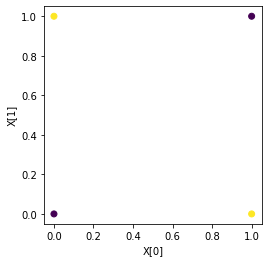

In [3]:
# Let's define a XOR dataset


# X will be matrix of N 2-dimensional inputs
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1],], dtype=np.float32)
# Y is a matrix of N numners - answers
Y = np.array([[0], [1], [1], [0],], dtype=np.float32)

plt.scatter(
    X[:, 0], X[:, 1], c=Y[:, 0],
)
plt.xlabel("X[0]")
plt.ylabel("X[1]")
plt.axis("square")

## Problem 1

The code below contains a mock-up of a two-layer neural network. Fill in the code and manually set weights to solve the XOR problem.

Please note: the shapes are set to be compatible with PyTorch's conventions:
* a batch containing $N$ $D$-dimensional examples has shape $N\times D$ (each example is a row!)
* a weight matrix in a linear layer with $I$ inputs and $O$ outputs has shape $O \times I$
* a bias vector is a 1D vector. Please note that [broadcasting rules](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) allow us to think about it as a $1 \times D$ matrix.

In [20]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))


class SmallNet:
    def __init__(self, in_features, num_hidden, dtype=np.float32):
        self.W1 = np.zeros((num_hidden, in_features), dtype=dtype)
        self.b1 = np.zeros((num_hidden,), dtype=dtype)
        self.W2 = np.zeros((1, num_hidden), dtype=dtype)
        self.b2 = np.zeros((1,), dtype=dtype)
        self.init_params()

    def init_params(self):
        # TODO for Problem 2:
        # set all parameters to small random values, e.g. from N(0, 0.5)
        self.W1 = np.random.standard_normal(self.W1.shape) * 0.5
        self.b1 = np.random.standard_normal(self.b1.shape) * 0.5
        self.W2 = np.random.standard_normal(self.W2.shape) * 0.5
        self.b2 = np.random.standard_normal(self.b2.shape) * 0.5
        

    def forward(self, X, Y=None, do_backward=False):
        # TODO Problem 1: Fill in details of forward propagation

        # Input to neurons in 1st layer
        A1 = X @ self.W1.T + self.b1
        # Outputs after the sigmoid non-linearity
        O1 = sigmoid(A1)
        # Inputs to neuron in the second layer
        A2 = O1 @ self.W2.T + self.b2 
        # Outputs after the sigmoid non-linearity
        O2 = sigmoid(A2)

        # When Y is none, simply return the predictions. Else compute the loss
        if Y is not None:
            loss = -Y * np.log(O2) - (1-Y) * np.log(1-O2) # TODO cross-entropy loss
            # normalize loss by batch size
            loss = loss.sum() / X.shape[0]
        else:
            loss = np.nan

        if do_backward:
            # TODO in Problem 2:
            # fill in the gradient computation
            # Please note, that there is a correspondance between
            # the forward and backward pass: with backward computations happening
            # in reverse order.
            # We save the gradients with respect to the parameters as fields of self.
            # It is not very elegant, but simplifies training code later on.

            # A2_grad is the gradient of loss with respect to A2
            # Hint: there is a concise formula for the gradient
            # of logistic sigmoid and cross-entropy loss
            A2_grad = O2 - Y
            self.b2_grad = A2_grad.sum(0) / X.shape[0]
            self.W2_grad = A2_grad.T @ O1 / X.shape[0]
            O1_grad = A2_grad @ self.W2
            A1_grad = O1_grad * O1 * (1 - O1)
            self.b1_grad = A1_grad.sum(0) / X.shape[0]
            self.W1_grad = A1_grad.T @ X / X.shape[0]

        return O2, loss
        

In [5]:
# TODO Problem 1:
# Set by hand the weight values to solve the XOR problem

net = SmallNet(2, 2, dtype=np.float64)
net.W1 = np.array([[20, 20],[20, 20]])
net.b1 = np.array([-10, -30])
net.W2 = np.array([[20, -20]])
net.b2 = np.array([-10])

# Hint: since we use the logistic sigmoid activation, the weights may need to
# be fairly large
predictions, loss = net.forward(X, Y, do_backward=True)
for x, p in zip(X, predictions):
    print(f"XORnet({x}) = {p[0]}")

XORnet([0. 0.]) = 4.543910487654575e-05
XORnet([0. 1.]) = 0.999954519621495
XORnet([1. 0.]) = 0.999954519621495
XORnet([1. 1.]) = 4.543910487654575e-05


## Problem 2

In [6]:
def check_grad(net, param_name, X, Y, eps=1e-5):
    """A gradient checking routine"""

    param = getattr(net, param_name)
    param_flat_accessor = param.reshape(-1)

    grad = np.zeros_like(param)
    grad_flat_accessor = grad.reshape(-1)

    net.forward(X, Y, do_backward=True)
    orig_grad = getattr(net, param_name + "_grad")
    assert param.shape == orig_grad.shape

    for i in range(param_flat_accessor.shape[0]):
        orig_val = param_flat_accessor[i]
        param_flat_accessor[i] = orig_val + eps
        _, loss_positive = net.forward(X, Y)
        param_flat_accessor[i] = orig_val - eps
        _, loss_negative = net.forward(X, Y)
        param_flat_accessor[i] = orig_val
        grad_flat_accessor[i] = (loss_positive - loss_negative) / (2 * eps)


    assert np.allclose(grad, orig_grad)
    return grad, orig_grad

In [7]:
# Hint: use float64 for checking the correctness of the gradient
net = SmallNet(2, 2, dtype=np.float64)

for param_name in ["W1", "b1", "W2", "b2"]:
    check_grad(net, param_name, X, Y)

## Problem 3

In [8]:
net = SmallNet(2, 10, dtype=np.float64)

alpha = 1  # set a learning rate

for i in range(100000):
    _, loss = net.forward(X, Y, do_backward=True)
    if (i % 5000) == 0:
        print(f"after {i} steps \tloss={loss}")
    for param_name in ["W1", "b1", "W2", "b2"]:
        param = getattr(net, param_name)
        # Hint: use the construct `param[:]` to change the contents of the array!
        # Doing instead `param = new_val` simply changes to what the variable
        # param points to, without affecting the network!
        # alternatively, you could do setattr(net, param_name, new_value)
        param_grad = getattr(net, param_name + "_grad")
        param[:] = param - alpha * param_grad

after 0 steps 	loss=0.7000094893230879
after 5000 steps 	loss=0.0016854397664548466
after 10000 steps 	loss=0.0007889465324727282
after 15000 steps 	loss=0.0005086587620667573
after 20000 steps 	loss=0.00037298243721898335
after 25000 steps 	loss=0.0002933393891413528
after 30000 steps 	loss=0.00024111970493297168
after 35000 steps 	loss=0.00020431832929697783
after 40000 steps 	loss=0.0001770278051701008
after 45000 steps 	loss=0.00015600821871180777
after 50000 steps 	loss=0.00013933656144413489
after 55000 steps 	loss=0.00012580050548778707
after 60000 steps 	loss=0.00011459848062412008
after 65000 steps 	loss=0.00010517964382566274
after 70000 steps 	loss=9.715316488501303e-05
after 75000 steps 	loss=9.02341875136118e-05
after 80000 steps 	loss=8.421027412916293e-05
after 85000 steps 	loss=7.89198225284126e-05
after 90000 steps 	loss=7.423775576705975e-05
after 95000 steps 	loss=7.006578078725038e-05


In [9]:
predictions, loss = net.forward(X, Y, do_backward=True)
for x, p in zip(X, predictions):
    print(f"XORnet({x}) = {p[0]}")

XORnet([0. 0.]) = 4.349562478594154e-05
XORnet([0. 1.]) = 0.9999404430628491
XORnet([1. 0.]) = 0.9999270237816725
XORnet([1. 1.]) = 8.926426025787873e-05


In [48]:
def gradient_descent(net, X, Y, params = ["W1", "b1", "W2", "b2"], iterations=100000, alpha = 1, debug=False):
    losses = []
    for i in range(iterations):
        _, loss = net.forward(X, Y, do_backward=True)
        losses.append(loss)
        if (i % 5000) == 0 and debug:
            print(f"after {i} steps \tloss={loss}")
        for param_name in params:
            param = getattr(net, param_name)
            # Hint: use the construct `param[:]` to change the contents of the array!
            # Doing instead `param = new_val` simply changes to what the variable
            # param points to, without affecting the network!
            # alternatively, you could do setattr(net, param_name, new_value)
            param_grad = getattr(net, param_name + "_grad")
            param[:] = param - alpha * param_grad
    predictions, loss = net.forward(X,Y)
    return predictions, loss, losses

0.0011099884327728832
0.00020988406255815898
5.436684974767829e-05
4.4579895617252746e-05
3.544222632836862e-05


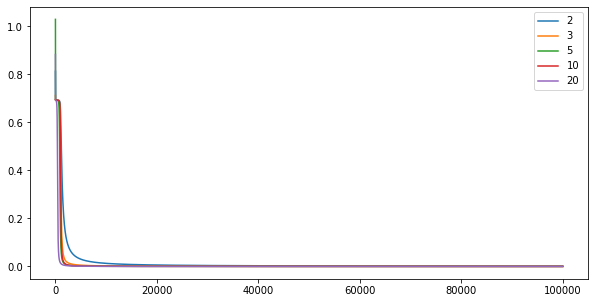

In [10]:
# TODO:
# Generate data for a 3D XOR task
# Then estimate the success rate of training the network with diferent
# hidden sizes.

X3 = np.array([[0,0,1], [0,1,0], [1,0,0], [1,1,1], [0,0,0], [1,1,0], [1,0,1], [0,1,1]])
Y3 = np.array([[1]] * 4 + [[0]] * 4)

plt.figure(figsize=(10,5))
for hidden_dim in [2, 3, 5, 10, 20]:
    net = SmallNet(3, hidden_dim)
    predictions, loss, losses = gradient_descent(net, X3, Y3, alpha=1)
    plt.plot(losses, label=hidden_dim)
    print(loss)
plt.legend()
plt.show()

## Problem 4


In [34]:
def relu(x):
    return x * (x > 0)

def d_relu(x):
    return 1. * (x > 0)


class SmallReluNet:
    def __init__(self, in_features, num_hidden, dtype=np.float32):
        self.W1 = np.zeros((num_hidden, in_features), dtype=dtype)
        self.b1 = np.zeros((num_hidden,), dtype=dtype)
        self.W2 = np.zeros((1, num_hidden), dtype=dtype)
        self.b2 = np.zeros((1,), dtype=dtype)
        self.init_params()

    def init_params(self):
        # TODO for Problem 2:
        # set all parameters to small random values, e.g. from N(0, 0.5)
        self.W1 = np.random.standard_normal(self.W1.shape) * 0.5
        self.b1 = np.random.standard_normal(self.b1.shape) * 0.5
        self.W2 = np.random.standard_normal(self.W2.shape) * 0.5
        self.b2 = np.random.standard_normal(self.b2.shape) * 0.5
        

    def forward(self, X, Y=None, do_backward=False):
        # TODO Problem 1: Fill in details of forward propagation

        # Input to neurons in 1st layer
        A1 = X @ self.W1.T + self.b1
        # Outputs after the sigmoid non-linearity
        O1 = relu(A1)
        # Inputs to neuron in the second layer
        A2 = O1 @ self.W2.T + self.b2 
        # Outputs after the sigmoid non-linearity
        O2 = sigmoid(A2)

        # When Y is none, simply return the predictions. Else compute the loss
        if Y is not None:
            loss = -Y * np.log(O2) - (1-Y) * np.log(1-O2) # TODO cross-entropy loss
            # normalize loss by batch size
            loss = loss.sum() / X.shape[0]
        else:
            loss = np.nan

        if do_backward:
            A2_grad = O2 - Y
            self.b2_grad = A2_grad.sum(0) / X.shape[0]
            self.W2_grad = A2_grad.T @ O1 / X.shape[0]
            O1_grad = A2_grad @ self.W2
            A1_grad = O1_grad * d_relu(A1)
            self.b1_grad = A1_grad.sum(0) / X.shape[0]
            self.W1_grad = A1_grad.T @ X / X.shape[0]

        return O2, loss

2 0.5753152172909426
3 0.2813309801414134
5 0.0008942384363761879
10 0.0004856772302621924
20 0.0004448099776332117


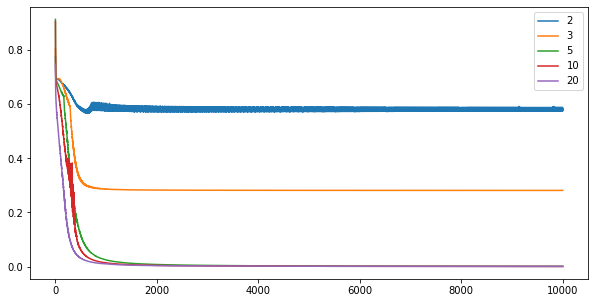

In [15]:
plt.figure(figsize=(10,5))
for hidden_dim in [2, 3, 5, 10, 20]:
    net = SmallReluNet(3, hidden_dim)
    predictions, loss, losses = gradient_descent(net, X3, Y3, iterations=10000, alpha=0.3)
    plt.plot(losses, label=hidden_dim)
    print(hidden_dim, loss)
plt.legend()
plt.show()

## Problem 5

In [3]:
class TwoLayerReluNet:
    def __init__(self, in_features, num_hidden_1, num_hidden_2, dtype=np.float32):
        self.W1 = np.zeros((num_hidden_1, in_features), dtype=dtype)
        self.b1 = np.zeros((num_hidden_1,), dtype=dtype)
        self.W2 = np.zeros((num_hidden_2, num_hidden_1), dtype=dtype)
        self.b2 = np.zeros((num_hidden_2,), dtype=dtype)
        self.W3 = np.zeros((1, num_hidden_2))
        self.b3 = np.zeros((1,))
        self.init_params()

    def init_params(self):
        # TODO for Problem 2:
        # set all parameters to small random values, e.g. from N(0, 0.5)
        self.W1 = np.random.standard_normal(self.W1.shape) * 0.5
        self.b1 = np.random.standard_normal(self.b1.shape) * 0.5
        self.W2 = np.random.standard_normal(self.W2.shape) * 0.5
        self.b2 = np.random.standard_normal(self.b2.shape) * 0.5
        self.W3 = np.random.standard_normal(self.W3.shape) * 0.5
        self.b3 = np.random.standard_normal(self.b3.shape) * 0.5
        

    def forward(self, X, Y=None, do_backward=False):
        A1 = X @ self.W1.T + self.b1
        O1 = relu(A1)
        A2 = O1 @ self.W2.T + self.b2 
        O2 = relu(A2)
        A3 = O2 @ self.W3.T + self.b3
        O3 = sigmoid(A3)

        # When Y is none, simply return the predictions. Else compute the loss
        if Y is not None:
            loss = -Y * np.log(O3) - (1-Y) * np.log(1-O3) # TODO cross-entropy loss
            # normalize loss by batch size
            loss = loss.sum() / X.shape[0]
        else:
            loss = np.nan

        if do_backward:
            A3_grad = O3 - Y
            self.b3_grad = A3_grad.sum(0) / X.shape[0]
            self.W3_grad = A3_grad.T @ O3 / X.shape[0]
            O2_grad = A3_grad @ self.W3
            A2_grad = O2_grad * d_relu(A2)
            self.b2_grad = A2_grad.sum(0) / X.shape[0]
            self.W2_grad = A2_grad.T @ O1 / X.shape[0]
            O1_grad = A2_grad @ self.W2
            A1_grad = O1_grad * d_relu(A1)
            self.b1_grad = A1_grad.sum(0) / X.shape[0]
            self.W1_grad = A1_grad.T @ X / X.shape[0]

        return O3, loss

In [50]:
class TwoLayerNet:
    def __init__(self, in_features, num_hidden_1, num_hidden_2, dtype=np.float32):
        self.W1 = np.zeros((num_hidden_1, in_features), dtype=dtype)
        self.b1 = np.zeros((num_hidden_1,), dtype=dtype)
        self.W2 = np.zeros((num_hidden_2, num_hidden_1), dtype=dtype)
        self.b2 = np.zeros((num_hidden_2,), dtype=dtype)
        self.W3 = np.zeros((1, num_hidden_2))
        self.b3 = np.zeros((1,))
        self.init_params()

    def init_params(self):
        self.W1 = np.random.standard_normal(self.W1.shape) * 0.5
        self.b1 = np.random.standard_normal(self.b1.shape) * 0.5
        self.W2 = np.random.standard_normal(self.W2.shape) * 0.5
        self.b2 = np.random.standard_normal(self.b2.shape) * 0.5
        self.W3 = np.random.standard_normal(self.W3.shape) * 0.5
        self.b3 = np.random.standard_normal(self.b3.shape) * 0.5
        

    def forward(self, X, Y=None, do_backward=False):
        A1 = X @ self.W1.T + self.b1
        O1 = sigmoid(A1)
        A2 = O1 @ self.W2.T + self.b2 
        O2 = sigmoid(A2)
        A3 = O2 @ self.W3.T + self.b3
        O3 = sigmoid(A3)

        # When Y is none, simply return the predictions. Else compute the loss
        if Y is not None:
            loss = -Y * np.log(O3) - (1-Y) * np.log(1-O3) # TODO cross-entropy loss
            # normalize loss by batch size
            loss = loss.sum() / X.shape[0]
        else:
            loss = np.nan

        if do_backward:
            A3_grad = O3 - Y
            self.b3_grad = A3_grad.sum(0) / X.shape[0]
            self.W3_grad = A3_grad.T @ O2 / X.shape[0]
            O2_grad = A3_grad @ self.W3
            A2_grad = O2_grad * O2 * (1 - O2)
            self.b2_grad = A2_grad.sum(0) / X.shape[0]
            self.W2_grad = A2_grad.T @ O1 / X.shape[0]
            O1_grad = A2_grad @ self.W2
            A1_grad = O1_grad * O1 * (1-O1)
            self.b1_grad = A1_grad.sum(0) / X.shape[0]
            self.W1_grad = A1_grad.T @ X / X.shape[0]

        return O3, loss

0.0004903100261699756


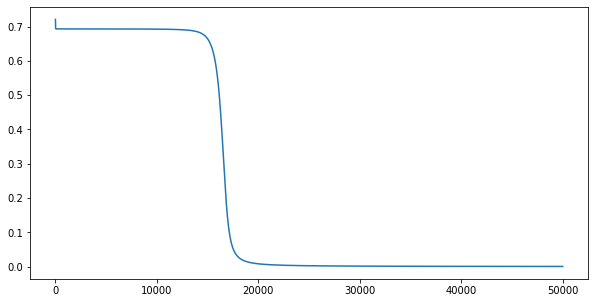

In [56]:
# TODO:
# Generate data for a 3D XOR task
# Then estimate the success rate of training the network with diferent
# hidden sizes.

X3 = np.array([[0,0,1], [0,1,0], [1,0,0], [1,1,1], [0,0,0], [1,1,0], [1,0,1], [0,1,1]])
Y3 = np.array([[1]] * 4 + [[0]] * 4)

net = TwoLayerNet(3, 5, 5)
params = ["W1", "b1", "W2", "b2", "W3", "b3"]
predictions, loss, losses = gradient_descent(net, X3, Y3, alpha=0.1, params=params, iterations=50000, debug=False)


plt.figure(figsize=(10,5))
plt.plot(losses)
print(loss)
# plt.legend()
plt.show()

## Problem 6

In [76]:
class NLayerNet:
    def __init__(self, in_features, nums_hidden, dtype=np.float32):
        self.W = [np.zeros((nums_hidden[0], in_features), dtype=dtype)]
        self.b = [np.zeros((nums_hidden[0],), dtype=dtype)]
        for i in range(1, len(nums_hidden)):
            n_out = nums_hidden[i]
            n_in = nums_hidden[i-1]
            self.W.append(np.zeros((n_out, n_in), dtype=dtype))
            self.b.append(np.zeros((n_out,), dtype=dtype))

        self.W.append(np.zeros((1, nums_hidden[-1]), dtype=dtype))
        self.b.append(np.zeros((1,), dtype=dtype))

        self.init_params()

    def init_params(self):
        for i in range(len(self.W)):
            self.W[i] = np.random.standard_normal(self.W[i].shape) * 0.5
            self.b[i] = np.random.standard_normal(self.b[i].shape) * 0.5

    def forward(self, X, Y=None, do_backward=False):
        A = [X @ self.W[0].T + self.b[0]]
        O = [sigmoid(A[0])]

        for i in range(1, len(self.W)):
            a = O[i-1] @ self.W[i].T + self.b[i]
            o = sigmoid(a)

            A.append(a)
            O.append(o)

        # When Y is none, simply return the predictions. Else compute the loss
        if Y is not None:
            loss = -Y * np.log(O[-1]) - (1-Y) * np.log(1-O[-1]) # TODO cross-entropy loss
            # normalize loss by batch size
            loss = loss.sum() / X.shape[0]
        else:
            loss = np.nan

        if do_backward:
            self.b_grad = [None] * len(self.b)
            self.W_grad = [None] * len(self.W)


            A_grad = O[-1] - Y


            for i in range(len(self.W)-1, 0 , -1):
                self.b_grad[i] = A_grad.sum(0) / X.shape[0]
                self.W_grad[i] = A_grad.T @ O[i-1] / X.shape[0]
                O_grad = A_grad @ self.W[i]
                A_grad = O_grad * O[i-1] * (1 - O[i-1])
                

            self.b_grad[0] = A_grad.sum(0) / X.shape[0]
            self.W_grad[0] = A_grad.T @ X / X.shape[0]

            
            # O2_grad = A3_grad @ self.W3
            # A2_grad = O2_grad * O2 * (1 - O2)
            # self.b2_grad = A2_grad.sum(0) / X.shape[0]
            # self.W2_grad = A2_grad.T @ O1 / X.shape[0]
            # O1_grad = A2_grad @ self.W2
            # A1_grad = O1_grad * O1 * (1-O1)
            # self.b1_grad = A1_grad.sum(0) / X.shape[0]
            # self.W1_grad = A1_grad.T @ X / X.shape[0]

        return O[-1], loss

In [77]:
def gradient_descent_2(net, X, Y, iterations=100000, alpha = 1, debug=False):
    losses = []
    for i in range(iterations):
        _, loss = net.forward(X, Y, do_backward=True)
        losses.append(loss)
        if (i % 5000) == 0 and debug:
            print(f"after {i} steps \tloss={loss}")
            
        for i in range(len(net.W)):
            net.b[i] -= alpha * net.b_grad[i]
            net.W[i] -= alpha * net.W_grad[i]
    predictions, loss = net.forward(X,Y)
    return predictions, loss, losses

layers: 1, loss: 0.0005625510540331678
layers: 2, loss: 0.00019928371681184943
layers: 3, loss: 0.00022107513677290292
layers: 5, loss: 0.6931484088186654
layers: 10, loss: 0.6931471821512042
layers: 20, loss: 0.6931471805599454
layers: 50, loss: 0.6931471805599453


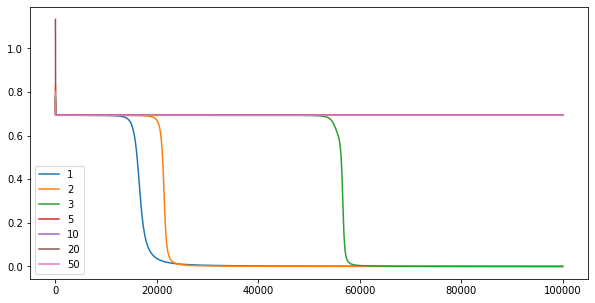

In [83]:
plt.figure(figsize=(10,5))
for num_layers in [1,2,3,5,10,20,50]:
    layers = [5] * num_layers
    net = NLayerNet(3, layers)
    predictions, loss, losses = gradient_descent_2(net, X3, Y3, alpha=0.1, iterations=100000, debug=False)
    plt.plot(losses, label=num_layers)
    print(f"layers: {num_layers}, loss: {loss}")

plt.legend()
plt.show()

after 0 steps 	loss=0.8098901961519345
after 5000 steps 	loss=0.6931466264803804
after 10000 steps 	loss=0.693146397992347
after 15000 steps 	loss=0.6931461416623613
after 20000 steps 	loss=0.6931458455475229
after 25000 steps 	loss=0.693145492925324
after 30000 steps 	loss=0.6931450594300668
after 35000 steps 	loss=0.6931445080939259
after 40000 steps 	loss=0.6931437803255021
after 45000 steps 	loss=0.6931427785398316
after 50000 steps 	loss=0.693141330380356
after 55000 steps 	loss=0.6931391086933054
after 60000 steps 	loss=0.6931354329860038
after 65000 steps 	loss=0.6931287055853568
after 70000 steps 	loss=0.6931144829888206
after 75000 steps 	loss=0.6930767159965998
after 80000 steps 	loss=0.6929185878197964
after 85000 steps 	loss=0.6854389750771719
after 90000 steps 	loss=0.0015089812708723258
after 95000 steps 	loss=0.0005548965311488589


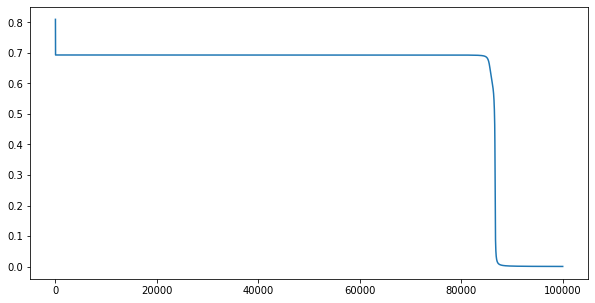

In [88]:
layers = [5] * 4
net = NLayerNet(3, layers)
predictions, loss, losses = gradient_descent_2(net, X3, Y3, alpha=0.3, iterations=100000, debug=True)
plt.figure(figsize=(10,5))
plt.plot(losses)
plt.show()

after 0 steps 	loss=0.73411267162899
after 5000 steps 	loss=0.6931464287615523
after 10000 steps 	loss=0.693146346217467
after 15000 steps 	loss=0.693146258995531
after 20000 steps 	loss=0.6931461664378127
after 25000 steps 	loss=0.6931460678007988
after 30000 steps 	loss=0.6931459622390379
after 35000 steps 	loss=0.6931458487852755
after 40000 steps 	loss=0.693145726326148
after 45000 steps 	loss=0.6931455935722322
after 50000 steps 	loss=0.6931454490208497
after 55000 steps 	loss=0.6931452909095221
after 60000 steps 	loss=0.693145117157226
after 65000 steps 	loss=0.6931449252896043
after 70000 steps 	loss=0.6931447123428471
after 75000 steps 	loss=0.6931444747388995
after 80000 steps 	loss=0.6931442081216589
after 85000 steps 	loss=0.6931439071393939
after 90000 steps 	loss=0.6931435651519451
after 95000 steps 	loss=0.693143173831039
after 100000 steps 	loss=0.6931427226060292
after 105000 steps 	loss=0.6931421978817106
after 110000 steps 	loss=0.6931415819126678
after 115000 steps 	

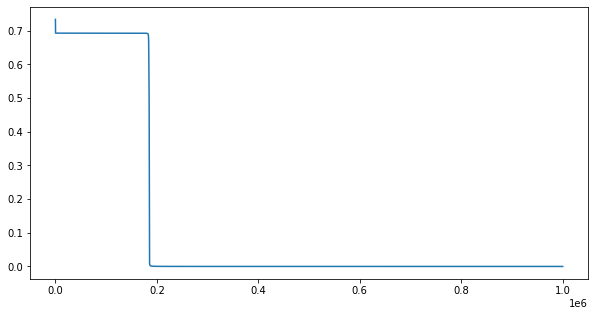

In [90]:
layers = [5] * 5
net = NLayerNet(3, layers)
predictions, loss, losses = gradient_descent_2(net, X3, Y3, alpha=0.3, iterations=1000000, debug=True)
plt.figure(figsize=(10,5))
plt.plot(losses)
plt.show()

after 0 steps 	loss=0.7189182341231595
after 5000 steps 	loss=0.6931474858191269
after 10000 steps 	loss=0.6931474834285622
after 15000 steps 	loss=0.6931474810654892
after 20000 steps 	loss=0.6931474787294716
after 25000 steps 	loss=0.6931474764200825
after 30000 steps 	loss=0.6931474741369035
after 35000 steps 	loss=0.6931474718795243
after 40000 steps 	loss=0.6931474696475431
after 45000 steps 	loss=0.6931474674405658
after 50000 steps 	loss=0.6931474652582061
after 55000 steps 	loss=0.6931474631000853
after 60000 steps 	loss=0.6931474609658321
after 65000 steps 	loss=0.6931474588550826
after 70000 steps 	loss=0.6931474567674794
after 75000 steps 	loss=0.6931474547026726
after 80000 steps 	loss=0.6931474526603185
after 85000 steps 	loss=0.6931474506400805
after 90000 steps 	loss=0.6931474486416278
after 95000 steps 	loss=0.6931474466646363
after 100000 steps 	loss=0.6931474447087884
after 105000 steps 	loss=0.6931474427737709
after 110000 steps 	loss=0.6931474408592785
after 115000 

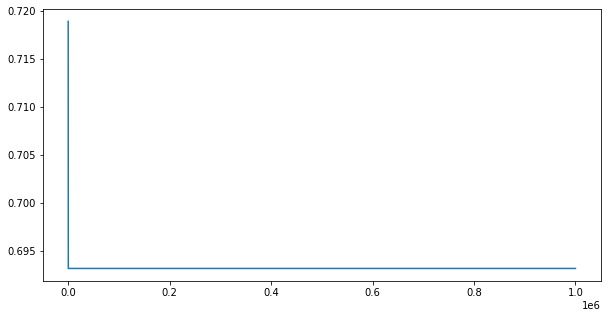

In [98]:
layers = [5] * 6
net = NLayerNet(3, layers)
predictions, loss, losses = gradient_descent_2(net, X3, Y3, alpha=0.2, iterations=1000000, debug=True)
plt.figure(figsize=(10,5))
plt.plot(losses)
plt.show()

## Problem 7